# Run level 2A, 2B and 3 pipelines on LRS-SLIT data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Feb 22nd 2019

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS-SLIT data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook are a dithered (nodded) MIRISim simulation of a point source with a power-law spectrum (alpha=0) plus emission lines. The following steps are applied:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps (Spec2Pipeline), including background subtraction using the nods, spectral extraction

- manual conversion of extracted spectrum to Jy using SRF


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0500.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'LRS-SLIT_demo_data'
input_dir = 'LRS-SLIT_demo_data'

# load all files including the background observation
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipeline'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-FIXEDSLIT	 P750L	 FULL	 2	 50	 FAST	 277.5



Filename: LRS-SLIT_demo_data/det_image_seq2_MIRIMAGE_P750Lexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  SCI           1 ImageHDU        57   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   6420R x 1C   [B]   


#### show the last frame of the first integration for each file

/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening LRS-SLIT_demo_data/det_image_seq2_MIRIMAGE_P750Lexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)
/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening LRS-SLIT_demo_data/det_image_seq1_MIRIMAGE_P750Lexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)


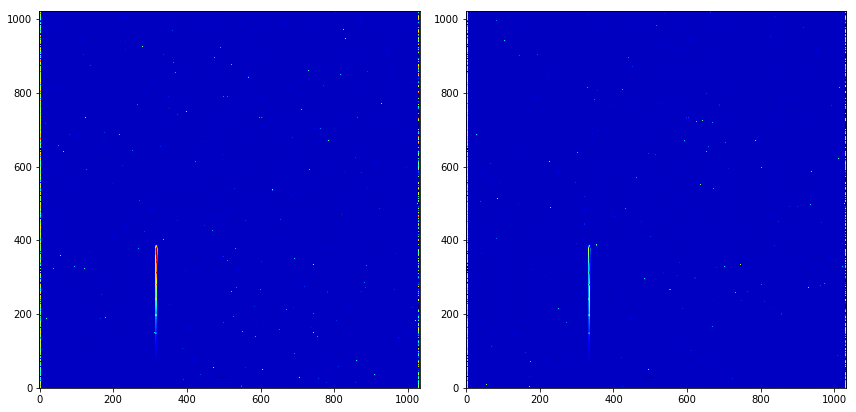

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

for n, f in enumerate(input_files):
    with datamodels.open(f) as in_dm:
        axs[n].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
                      norm=LogNorm(vmin=1e4,vmax=5e4))
        axs[n].set_facecolor('black')

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)


    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'. 

Note that we must explicitly skip the IPC step.

There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.

In [6]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})


2019-02-22 09:30:24,985 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-22 09:30:24,989 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-22 09:30:24,990 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-22 09:30:24,992 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-22 09:30:24,994 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-22 09:30:24,995 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-22 09:30:24,997 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-22 09:30:24,999 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-22 09:30:25,000 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-22 09:30:25,003 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-22 

2019-02-22 09:31:18,019 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-22 09:31:18,020 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-22 09:31:18,079 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1.fits>,).
2019-02-22 09:31:18,094 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-22 09:31:18,099 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-02-22 09:31:18,241 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-02-22 09:31:21,530 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-22 09:31:22,338 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-22 09:3

2019-02-22 09:38:09,520 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-22 09:38:09,521 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-22 09:38:09,523 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-22 09:38:09,580 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1.fits>,).
2019-02-22 09:38:09,598 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits
2019-02-22 09:38:11,989 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-22 09:38:12,096 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1.fits>,).
2019-02-22 09:38:12,119 - stpipe.Detector1Pipeline.saturation - INFO

#### Quick check of the pipeline steps applied in the output:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


The bkg_subtract subtract step requires an association file defining the source and background exposures. At the moment, there is no easy way to create one, so we define it manually in a cell and write to the association json file. 

Note that the first nod in the MIRISim simulations is actually the background nod so we define this in the association file.

In [12]:
import json

data = {
        "degraded_status": "No known degraded exposures in association.",
        "asn_rule": "DMS_Level3_Base",
        "asn_pool": "none",
        "asn_type": "None",
        "constraints": "No constraints",
        "program": "none",
        "code_version": "0.7.2.beta5",
        "asn_id": "a3001",
        "products": [
        {
            "name": "lrs_bgsub_1",
            "members": [
                {
                    "expname": "LRS-SLIT_demo_data_pipeline/det_image_seq2_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "LRS-SLIT_demo_data_pipeline/det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ],
    "target": "none"
}

with open('LRS_lvl2_asn.json', 'w') as outfile:  
    json.dump(data, outfile)

#### run pipeline
We pass the level 2 assocation file. The output is contained in the dm_2B data model and saved to a fits file ending in '_cal.fits'.

The call to the pipeline will also extract a spectrum from this _cal.fits file (ending in _x1d.fits). 

In [14]:
Spec2Pipeline.call('LRS_lvl2_asn.json', save_results=True, output_dir=output_dir, 
                   steps={'extract_1d':{'save_results':True}})


2019-02-22 10:38:11,875 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-22 10:38:11,878 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-22 10:38:11,881 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-22 10:38:11,884 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-22 10:38:11,886 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-22 10:38:11,889 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2019-02-22 10:38:11,890 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-02-22 10:38:11,892 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-02-22 10:38:11,893 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2019-02-22 10:38:11,895 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-02-22 10:38:1

2019-02-22 10:38:12,343 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2019-02-22 10:38:12,344 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.
2019-02-22 10:38:12,344 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2019-02-22 10:38:12,345 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2019-02-22 10:38:12,346 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2019-02-22 10:38:12,346 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2019-02-22 10:38:12,347 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.
2019-02-22 10:38:12,347 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2019-02-22 10:38:12,348 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.
2019-02-22 10:38:12,349 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file i

2019-02-22 10:38:15,586 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1
2019-02-22 10:38:15,590 - stpipe.Spec2Pipeline.extract_1d - INFO - Total number of dither points = None; assuming no nod/dither offset
2019-02-22 10:38:15,631 - stpipe.Spec2Pipeline.extract_1d - WARNING - Using RELSENS, 387 elements were extrapolated; these values will be set to 1.
2019-02-22 10:38:15,727 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in LRS-SLIT_demo_data_pipeline/lrs_bgsub_1_x1d.fits
2019-02-22 10:38:15,728 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2019-02-22 10:38:15,729 - stpipe.Spec2Pipeline - INFO - Finished processing product lrs_bgsub_1
2019-02-22 10:38:15,729 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-22 10:38:15,964 - stpipe.Spec2Pipeline - INFO - Saved model in LRS-SLIT_demo_data_pipeline/lrs_bgsub_1_cal.fits
2019-02-22 10:38:15,965 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


[<ImageModel(1024, 1032) from lrs_bgsub_1_cal.fits>]

### check of output

We can have a look at the steps applied to the level 2B file in the pipeline

In [15]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('bkg_subtract: %s' % dm.meta.cal_step.back_sub)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
bkg_subtract: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
photom: COMPLETE


While the photom step attaches the SRF to the _cal.fits file, it does not actually apply it so we must manually convert the extracted spectrum from DN/s to Jy using the SRF. We can look at the SRF while is located in the 'relsens' object in the metadata.

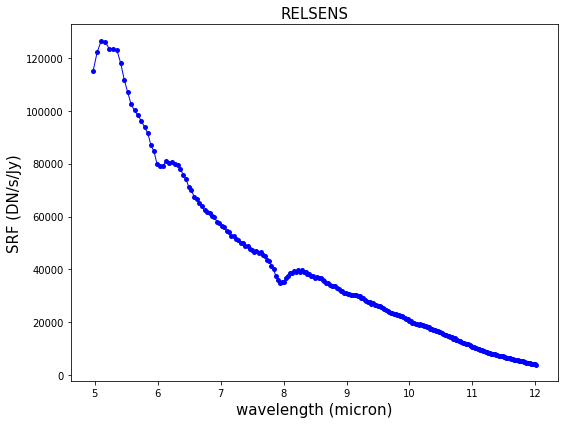

In [16]:
with datamodels.open(level2B_files[0]) as dm:  
    #print(dm.relsens)
    relsens = np.array(dm.relsens, dtype=[('wavelength', 'f4'), ('response', 'i8')])
    # plot--------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))

    # plot input and output ramps of the first integration
    axs.plot(relsens['wavelength'], relsens['response'], c='b', marker='o', markersize=2, 
             markeredgewidth=3, linestyle='-', linewidth=1, label='relsens')
    axs.set_title('RELSENS', fontsize=15)
    axs.set_xlabel('wavelength (micron)', fontsize=15)
    axs.set_ylabel('SRF (DN/s/Jy)', fontsize=15)

    plt.tight_layout(h_pad=0)
    plt.show()

#### plot the spectrum
Using the SRF, we can flux calibrate and plot the extracted spectrum

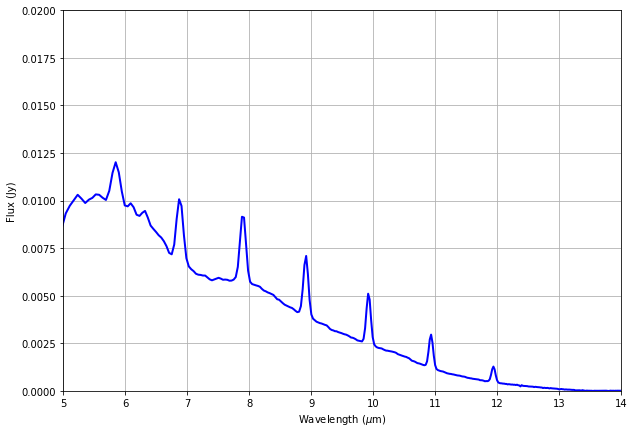

In [17]:
spec_file = glob.glob(os.path.join(output_dir,"*x1d.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# convert the flux to Jy
response_at_data = np.interp(dm.spec[0].spec_table['WAVELENGTH'][1:-1], relsens['wavelength'], relsens['response'])
flux_Jy = dm.spec[0].spec_table['FLUX'][1:-1] / response_at_data

# plot the spectrum 
axs.plot(dm.spec[0].spec_table['WAVELENGTH'][1:-1], flux_Jy, c='b', marker='.', 
         markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux (Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')
axs.set_xlim(5.0,14.0)
axs.set_ylim(0,0.02)
plt.grid()
plt.show()

Note that this spectrum does not look like the MIRISim input (power law with alpha=0 plus emission lines at integer wavelengths). This is due to known differences in the simulator/pipeline reference files, i.e., some calibration files for the LRS have been updated in MIRISim, but have yet to filter through to the JWST pipeline. As such there are a few discrepancies from expected performance, including:

1. a 0.2-0.3 micron wavelength offset in slit mode. 

2. some flux discrepancies at long wavelengths because of a mis-match between the Spectral Response Function and Photon Conversion Efficiency when compared to the ETC. This mis-match is being investigated.